<a href="https://colab.research.google.com/github/saritmaitra/neural_network_imbalanced_class/blob/main/Neural_Network_imbalanced_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

!pip install gdown
import gdown
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import f1_score, cohen_kappa_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
url = 'https://drive.google.com/uc?id=18gwvNkMs6t0jL0APl9iWPrhr5GVg082S' 
output = 'insurance_claim_prediction.csv'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=18gwvNkMs6t0jL0APl9iWPrhr5GVg082S
To: /content/insurance_claim_prediction.csv
116MB [00:01, 58.1MB/s]


'insurance_claim_prediction.csv'

In [3]:
df = pd.read_csv('insurance_claim_prediction.csv')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              595212 non-null  int64  
 1   target          595212 non-null  int64  
 2   ps_ind_01       595212 non-null  int64  
 3   ps_ind_02_cat   595212 non-null  int64  
 4   ps_ind_03       595212 non-null  int64  
 5   ps_ind_04_cat   595212 non-null  int64  
 6   ps_ind_05_cat   595212 non-null  int64  
 7   ps_ind_06_bin   595212 non-null  int64  
 8   ps_ind_07_bin   595212 non-null  int64  
 9   ps_ind_08_bin   595212 non-null  int64  
 10  ps_ind_09_bin   595212 non-null  int64  
 11  ps_ind_10_bin   595212 non-null  int64  
 12  ps_ind_11_bin   595212 non-null  int64  
 13  ps_ind_12_bin   595212 non-null  int64  
 14  ps_ind_13_bin   595212 non-null  int64  
 15  ps_ind_14       595212 non-null  int64  
 16  ps_ind_15       595212 non-null  int64  
 17  ps_ind_16_

features that belong to similar groupings are tagged as such in the feature names (e.g., ind, reg, car, calc). In addition, feature names include the postfix bin to indicate binary features and cat to indicate categorical features. Features without these designations are either continuous or ordinal. Values of -1 indicate that the feature was missing from the observation. The target columns signifies whether or not a claim was filed for that policy holder.

Insurance claims:
    Total: 595212
   Suspicious claims: 21694 (3.64% of total)



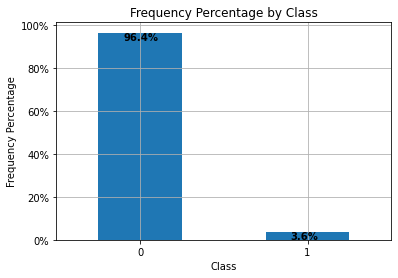

In [15]:
# no_claim, claim = df.target.value_counts()
# print(f'No claim {no_claim}')
# print(f'Claim {claim}')

neg, pos = np.bincount(df['target'])
total = neg + pos
print('Insurance claims:\n    Total: {}\n   Suspicious claims: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

ax = (df['target'].value_counts() /len(df)*100).plot(kind='bar', stacked = True, rot = 0)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('Frequency Percentage')
ax.set_xlabel('Class')
ax.set_title('Frequency Percentage by Class')
totals = []  # list to collect the plt.patches data
# values and append to list
for i in ax.patches:
  totals.append(i.get_width())
total = sum(totals)  # setting individual bar lables using above list
for i in ax.patches:
  ax.text(i.get_x()+.15, i.get_height()-3.5, \
  str(round((i.get_height()/total), 1))+'%', color='black', weight = 'bold')
plt.grid(True)

In [ ]:
# Count total NaN at each column in a DataFrame
print(" \nCount total NaN at each column in a DataFrame : \n\n",
      df.isnull().sum())

 
Count total NaN at each column in a DataFrame : 

 id                0
target            0
ps_ind_01         0
ps_ind_02_cat     0
ps_ind_03         0
ps_ind_04_cat     0
ps_ind_05_cat     0
ps_ind_06_bin     0
ps_ind_07_bin     0
ps_ind_08_bin     0
ps_ind_09_bin     0
ps_ind_10_bin     0
ps_ind_11_bin     0
ps_ind_12_bin     0
ps_ind_13_bin     0
ps_ind_14         0
ps_ind_15         0
ps_ind_16_bin     0
ps_ind_17_bin     0
ps_ind_18_bin     0
ps_reg_01         0
ps_reg_02         0
ps_reg_03         0
ps_car_01_cat     0
ps_car_02_cat     0
ps_car_03_cat     0
ps_car_04_cat     0
ps_car_05_cat     0
ps_car_06_cat     0
ps_car_07_cat     0
ps_car_08_cat     0
ps_car_09_cat     0
ps_car_10_cat     0
ps_car_11_cat     0
ps_car_11         0
ps_car_12         0
ps_car_13         0
ps_car_14         0
ps_car_15         0
ps_calc_01        0
ps_calc_02        0
ps_calc_03        0
ps_calc_04        0
ps_calc_05        0
ps_calc_06        0
ps_calc_07        0
ps_calc_08        0
ps_calc

In [4]:
df.drop(["ps_car_03_cat", "ps_car_05_cat", "ps_reg_03"], inplace=True, axis=1)

cat_columns = [
  'ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat',
  'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_07_cat',
  'ps_car_09_cat'
]
num_columns = ['ps_car_11', 'ps_car_12', 'ps_car_14']
mean_imp = SimpleImputer(missing_values=-1, strategy='mean')
cat_imp = SimpleImputer(missing_values=-1, strategy='most_frequent')
for c in cat_columns:
  df[c] = cat_imp.fit_transform(df[[c]]).ravel()
for c in num_columns:
  df[c] = mean_imp.fit_transform(df[[c]]).ravel()

In [5]:
df = pd.get_dummies(df, columns=cat_columns)
df.tail()

,id,target,ps_ind_01,ps_ind_03,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_car_04_cat,ps_car_06_cat,ps_car_08_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,...,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin,ps_ind_02_cat_1,ps_ind_02_cat_2,ps_ind_02_cat_3,ps_ind_02_cat_4,ps_ind_04_cat_0,ps_ind_04_cat_1,ps_ind_05_cat_0,ps_ind_05_cat_1,ps_ind_05_cat_2,ps_ind_05_cat_3,ps_ind_05_cat_4,ps_ind_05_cat_5,ps_ind_05_cat_6,ps_car_01_cat_0,ps_car_01_cat_1,ps_car_01_cat_2,ps_car_01_cat_3,ps_car_01_cat_4,ps_car_01_cat_5,ps_car_01_cat_6,ps_car_01_cat_7,ps_car_01_cat_8,ps_car_01_cat_9,ps_car_01_cat_10,ps_car_01_cat_11,ps_car_02_cat_0,ps_car_02_cat_1,ps_car_07_cat_0,ps_car_07_cat_1,ps_car_09_cat_0,ps_car_09_cat_1,ps_car_09_cat_2,ps_car_09_cat_3,ps_car_09_cat_4
595207,1488013,0,3,10,0,0,0,1,0,0,0,0,0,13,1,0,0,0.5,0.3,0,1,1,1,31,3.0,0.374166,0.684631,0.385487,2.645751,0.4,0.5,0.3,3,0,9,0,9,1,12,4,...,0,1,1,0,1,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,1,0,0,0,0
595208,1488016,0,5,3,0,0,0,1,0,0,0,0,0,6,1,0,0,0.9,0.7,0,15,0,1,63,2.0,0.387298,0.972145,0.374691,3.605551,0.2,0.2,0.0,2,4,8,6,8,2,12,4,...,1,0,1,0,1,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0
595209,1488017,0,1,10,1,0,0,0,0,0,0,0,0,12,1,0,0,0.9,0.2,0,1,1,1,31,3.0,0.397492,0.596373,0.398748,1.732051,0.4,0.0,0.3,3,2,7,4,8,0,10,3,...,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0
595210,1488021,0,5,3,0,0,1,0,0,0,0,0,0,12,1,0,0,0.9,0.4,0,11,1,1,101,3.0,0.374166,0.764434,0.384968,3.162278,0.0,0.7,0.0,4,0,9,4,9,2,11,4,...,0,1,1,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0
595211,1488027,0,0,8,1,0,0,0,0,0,0,0,0,7,1,0,0,0.1,0.2,0,0,0,1,34,2.0,0.400000,0.932649,0.378021,3.741657,0.4,0.0,0.5,2,3,10,4,10,2,5,4,...,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0


In [6]:
labels = df.columns[2:]
X = df[labels]
y = df['target']
X_train, X_test, y_train, y_test = \
  train_test_split(X, y, test_size=0.20, random_state=RANDOM_SEED)

print(X_train.shape, y_train.shape)

(476169, 81) (476169,)


In [12]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def createModel(train_data, metrics=METRICS,
                output_bias = None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
    keras.layers.Dense(
      units=36, 
      activation='relu',
      input_shape=(train_data.shape[-1],)
    ),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(units=1, activation='sigmoid',
                       bias_initializer=output_bias),
  ])

  model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[METRICS],
    
  )

  return model

## Weighted Neural Network With Keras

Initial bias: [-3.2747536]

Steps/Epoch: 232
Class weights: {0: 0.5188608725973064, 1: 13.754954070136924}

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
dict_keys(['loss', 'tp', 'fp', 'tn', 'fn', 'accuracy', 'precision', 'recall', 'auc', 'prc', 'val_loss', 'val_tp', 'val_fp', 'val_tn', 'val_fn', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc', 'val_prc'])


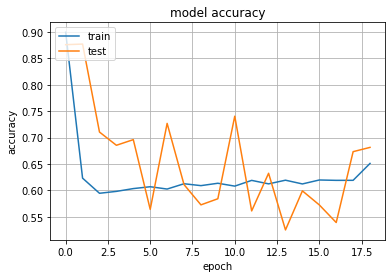

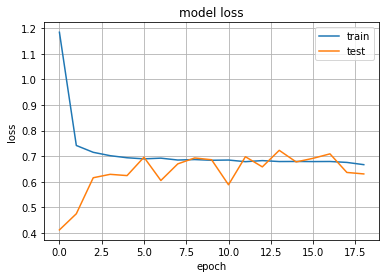

In [16]:
#  by setting initial bias the model will give much more reasonable initial guesses
initial_bias = np.log([pos/neg])
print('Initial bias:', initial_bias); print()

weightedModel = createModel(X_train, output_bias=initial_bias)
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True
    )

steps_per_epoch = len(X_train) // BATCH_SIZE
print('Steps/Epoch:', steps_per_epoch)

# Setting up class weights

"""
The goal is to identify fraudulent transactions, but we don't have very many of those positive 
samples to work with, so we would want to have the classifier heavily weight the few examples that are available. 
We can do this by passing Keras weights for each class through a parameter. 
These will cause the model to "pay more attention" to examples from an under-represented class.
"""

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
class_weights = dict(enumerate(class_weights))
print('Class weights:',class_weights);print()

# Fit the model
history = weightedModel.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=20,
    callbacks=[early_stopping],
    validation_split=0.10,
    steps_per_epoch=steps_per_epoch,
    shuffle=True,
    verbose=0,
    class_weight=class_weights,
    )

# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True); plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.grid(True); plt.show()

In [17]:
predictions = weightedModel.predict(X_test, batch_size=BATCH_SIZE)
predictions = np.round(predictions.flatten())
# This way the model doesn't need to spend the first few epochs just learning that positive examples are unlikely. 
# This also makes it easier to read plots of the loss during training.
results = weightedModel.evaluate(X_test.values, y_test.values, batch_size=BATCH_SIZE, verbose=0)

for name, value in zip(weightedModel.metrics_names, results):
  print(name, ': ', value)

print(f'f1 score: {f1_score(y_test, predictions)}')
print(f'Mathews Correlation Coeff: {matthews_corrcoef(y_test.values, predictions)}')
print(f'Cohen Kappa: {cohen_kappa_score(y_test.values, predictions)}')

loss :  0.6299728155136108
tp :  2163.0
fp :  35469.0
tn :  79189.0
fn :  2222.0
accuracy :  0.6833832859992981
precision :  0.0574776791036129
recall :  0.4932725131511688
auc :  0.6290343403816223
prc :  0.06453555822372437
f1 score: 0.1029583263916986
Mathews Correlation Coeff: 0.07450939009688405
Cohen Kappa: 0.03958805881280503


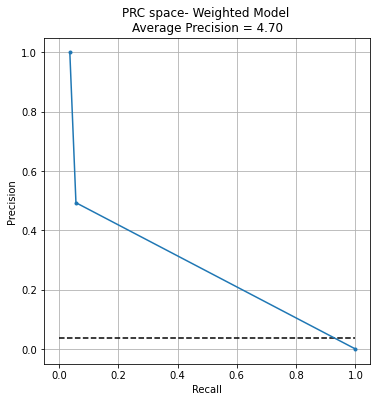

In [18]:
def precision_recall(name, labels, predictions, **kwargs):
    average_precision = round(average_precision_score(y_test, predictions)*100, 2)
    precision, recall, _ = precision_recall_curve(labels, predictions)
    plt.figure(figsize=(10,6))
    no_skill = len(y[y==1]) / len(y)
    plt.plot([0, 1], [no_skill, no_skill], 'k--', label='No Skill')
    plt.plot(precision, recall, marker='.', label='Weighted Model', **kwargs)
    plt.title('PRC space- Weighted Model \nAverage Precision = {0:0.2f}'.format(average_precision))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

precision_recall('Test prediction:', y_test, predictions)

The plot of the precision-recall curve highlights that the weighted model is just above the no skill line for most thresholds.

This is possible because the model predicts probabilities and is uncertain about some cases. These get exposed through the different thresholds evaluated in the construction of the curve, flipping some class 0 to class 1, offering some precision but very low recall.

# Legitimate class identified (True Negatives):  79189
# Legitimate Incorrectly identified (False Positives):  35469
# Suspicious class Missed (False Negatives):  2222
# Suspicious class Detected (True Positives):  2163
Total Suspicious claims:  4385



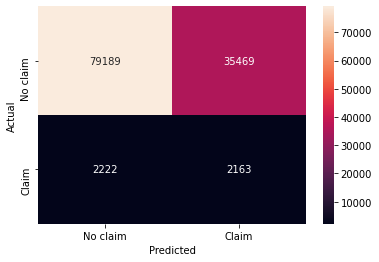

In [19]:
def conf_matrix(labels, predictions, p=0.5):

  tick_labels = ['No claim', 'Claim']

  cm = confusion_matrix(labels, predictions > p)
  ax = sns.heatmap(cm, annot=True, fmt="d")
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  ax.set_xticklabels(tick_labels)
  ax.set_yticklabels(tick_labels)

  print('# Legitimate class identified (True Negatives): ', cm[0][0])
  print('# Legitimate Incorrectly identified (False Positives): ', cm[0][1])
  print('# Suspicious class Missed (False Negatives): ', cm[1][0])
  print('# Suspicious class Detected (True Positives): ', cm[1][1])
  print('Total Suspicious claims: ', np.sum(cm[1])); print()

model_pred = weightedModel.predict(X_test.values, batch_size=BATCH_SIZE)
conf_matrix(y_test, model_pred)